In [2]:
import argparse
import numpy as np
import pandas as pd
import patsy
import pickle
import re
import scipy.stats as ss
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
import statsmodels.api as sm
import sys

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
%matplotlib inline

In [4]:
def dprint(s):
    if debug:
        print('debug: {}'.format(s))

In [5]:
def unpickle_data(fn='my_data.pkl'):
    # Load it back.
    with open(fn, 'rb') as picklefile:
        d = pickle.load(picklefile)
    return d

In [6]:
debug = True

In [7]:
base_dir = '/home/crh/git/nyc17_ds12/student_submissions/projects/02-luther/harwell_chris'
data1 = unpickle_data(fn=base_dir + '/edu_sal/sal_each_page91953_91969.pkl')
data2 = unpickle_data(fn=base_dir + '/edu_sal/sal_each_page91969_92545.pkl')
data = data1
data1.update(data2)
dprint(repr(data['headers']))
# dprint(repr(data['salaries']))
# Filter based on
desired_district = 'Sch Dist Of The Chathams'
dprint('number of records before {}'.format(len(data['salaries'])))
data['salaries'] = [r for r in data['salaries'] if r[4] == desired_district]
dprint('number of records after {}'.format(len(data['salaries'])))

debug: ['first', 'last', 'salary', 'county', 'district', 'experience_district', 'school', 'experience_nj', 'primary_job', 'experience_total', 'fte', 'subcategory', 'certificate', 'highly_qualified', 'teaching_route']
debug: number of records before 577
debug: number of records after 395


In [8]:
# Convert our lists to a dataframe.
df = pd.DataFrame(data['salaries'], columns=data['headers'])
# dprint(repr(df))
dprint(repr(df.dtypes))

debug: first                   object
last                    object
salary                 float64
county                  object
district                object
experience_district     object
school                  object
experience_nj           object
primary_job             object
experience_total        object
fte                     object
subcategory             object
certificate             object
highly_qualified        object
teaching_route          object
dtype: object


In [9]:
# Git rid of the N/A
df2 = df.replace('N/A', np.NaN)
dprint('Len before dropna: {}'.format(len(df2)))
n = ['salary', 'experience_district', 'experience_nj', 'experience_total', 'fte']
df3 = df2.dropna(subset=n)
dprint('Len after dropna: {}'.format(len(df3)))

debug: Len before dropna: 395
debug: Len after dropna: 393


In [10]:
df4 = df3
df4[n] = df3[n].apply(pd.to_numeric)

/usr/lib64/python3.5/site-packages/pandas/core/frame.py:2438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [11]:
for idx, val in enumerate(df4.columns):
    print('{} column: {}'.format(idx + 1, val))
dprint('row * column: {}'.format(df4.shape))

1 column: first
2 column: last
3 column: salary
4 column: county
5 column: district
6 column: experience_district
7 column: school
8 column: experience_nj
9 column: primary_job
10 column: experience_total
11 column: fte
12 column: subcategory
13 column: certificate
14 column: highly_qualified
15 column: teaching_route
debug: row * column: (393, 15)


In [12]:
print('correlations: {}'.format(df4.corr()))

correlations:                        salary  experience_district  experience_nj  \
salary               1.000000             0.449013       0.648880   
experience_district  0.449013             1.000000       0.859131   
experience_nj        0.648880             0.859131       1.000000   
experience_total     0.651503             0.848914       0.990810   
fte                  0.221986            -0.098855      -0.086944   

                     experience_total       fte  
salary                       0.651503  0.221986  
experience_district          0.848914 -0.098855  
experience_nj                0.990810 -0.086944  
experience_total             1.000000 -0.083084  
fte                         -0.083084  1.000000  


In [13]:
print('The "experience_total" and "experience_nj" columns are highly correlated (0.99).')
print('- either they are not including other states or we do not have any.')
print('The nj and district experience are also high (0.85).')


The "experience_total" and "experience_nj" columns are highly correlated (0.99).
- either they are not including other states or we do not have any.
The nj and district experience are also high (0.85).


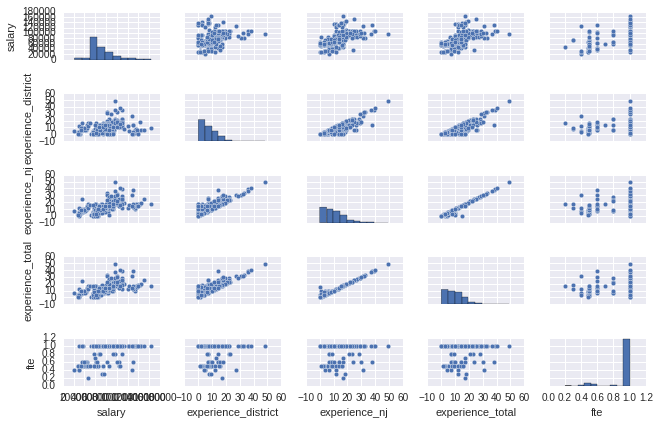

In [14]:
sns.pairplot(df4, size=1.2, aspect=1.5)

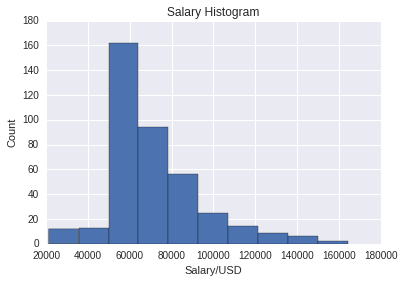

In [15]:
sal = df4.salary
ax = sal.hist()
ax.set_xlabel('Salary/USD')
ax.set_ylabel('Count')
ax.set_title('Salary Histogram')

In [16]:
print('average: {:,.0f}'.format(sal.mean()))
print('middle: {:,.0f}'.format(sal.median()))
print('min,max range: {:,.0f} through {:,.0f}'.format(sal.min(), sal.max()))
print('iqr range for dispersion: {:,.0f}'.format(ss.iqr(sal)))

average: 71,931
middle: 65,035
min,max range: 21,236 through 164,303
iqr range for dispersion: 22,884


In [17]:
ss.describe(sal)

DescribeResult(nobs=393, minmax=(21236.0, 164303.0), mean=71931.325699745546, variance=475049866.43446535, skewness=1.1999130808179492, kurtosis=2.1010797452043084)

In [18]:
print('Looks skewed at 1.2 (vs. 0 for normal)')

Looks skewed at 1.2 (vs. 0 for normal)


In [19]:
ss.normaltest(sal)

NormaltestResult(statistic=86.716775754067598, pvalue=1.4780577426373062e-19)

In [20]:
df5 = df4[n]

In [21]:
y, X1 = patsy.dmatrices('salary ~ experience_district ', data=df5, return_type="dataframe")
model_experience_district = sm.OLS(y, X1)
fit_experience_district = model_experience_district.fit()
fit_experience_district.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     98.74
Date:                Mon, 17 Jul 2017   Prob (F-statistic):           6.79e-21
Time:                        08:59:46   Log-Likelihood:                -4438.8
No. Observations:                 393   AIC:                             8882.
Df Residuals:                     391   BIC:                             8889.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            6.137e+04   1448.301     42.373      0.000      5.85e+04  6.42e+04
experience_district  1395.3776    140.427      9.937      0.000      1119.291  1671.465
==============================================================================
Omnibus:                      137.975   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              541.528
Skew:                           1.519   Prob(JB):                    2.56e-118
Kurtosis:                       7.882   Cond. No.                         15.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

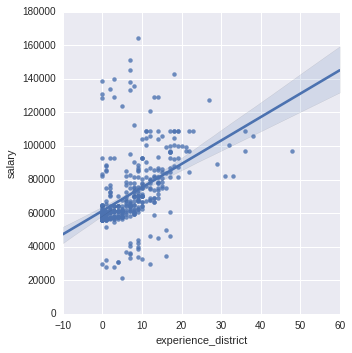

In [22]:
sns.lmplot('experience_district', 'salary', data=df4)
plt.title='Salary as a function of experience'

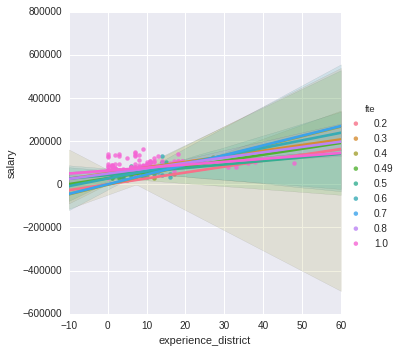

In [23]:
sns.lmplot('experience_district', 'salary', data=df4, hue='fte')

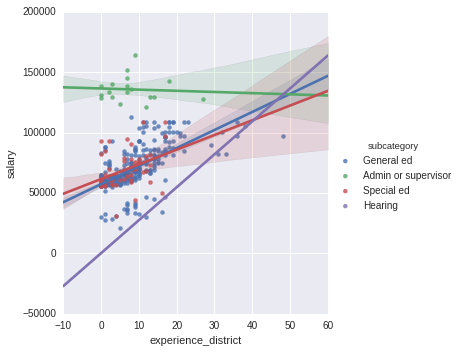

In [24]:
sns.lmplot('experience_district', 'salary', data=df4, hue='subcategory')

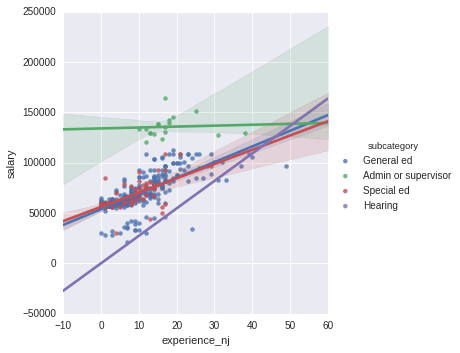

In [25]:
sns.lmplot('experience_nj', 'salary', data=df4, hue='subcategory')

In [26]:
y, X2 = patsy.dmatrices('salary ~ experience_nj ', data=df5, return_type="dataframe")
model_experience_nj = sm.OLS(y, X2)
fit_experience_nj = model_experience_nj.fit()
fit_experience_nj.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     284.4
Date:                Mon, 17 Jul 2017   Prob (F-statistic):           2.45e-48
Time:                        08:59:49   Log-Likelihood:                -4375.6
No. Observations:                 393   AIC:                             8755.
Df Residuals:                     391   BIC:                             8763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      5.407e+04   1350.180     40.050      0.000      5.14e+04  5.67e+04
experience_nj  1792.9873    106.328     16.863      0.000      1583.942  2002.033
==============================================================================
Omnibus:                       89.375   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              400.315
Skew:                           0.901   Prob(JB):                     1.18e-87
Kurtosis:                       7.604   Cond. No.                         20.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
y, X3 = patsy.dmatrices('salary ~ experience_district + experience_nj + fte', data=df5, return_type="dataframe")
model_exp_both_fte = sm.OLS(y, X3)
fit_exp_both_fte = model_exp_both_fte.fit()
fit_exp_both_fte.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     151.4
Date:                Mon, 17 Jul 2017   Prob (F-statistic):           5.09e-65
Time:                        08:59:49   Log-Likelihood:                -4331.0
No. Observations:                 393   AIC:                             8670.
Df Residuals:                     389   BIC:                             8686.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            1.796e+04   4761.009      3.771      0.000      8595.270  2.73e+04
experience_district -1209.2907    209.348     -5.776      0.000     -1620.886  -797.695
experience_nj        2781.8870    185.936     14.962      0.000      2416.322  3147.453
fte                  3.753e+04   4791.543      7.833      0.000      2.81e+04   4.7e+04
==============================================================================
Omnibus:                      108.584   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.230
Skew:                           1.200   Prob(JB):                     3.02e-85
Kurtosis:                       7.244   Cond. No.                         144.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

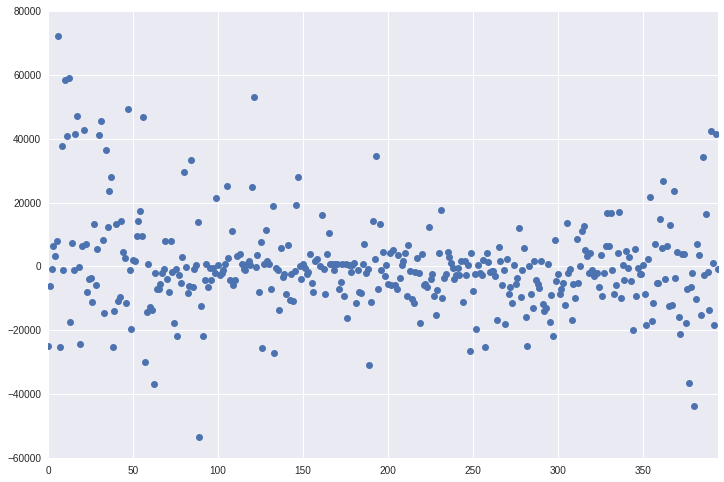

In [28]:
fit_exp_both_fte.resid.plot(style='o', figsize=(12,8))

In [29]:
y, X4 = patsy.dmatrices('salary ~ experience_district + experience_nj', data=df5, return_type="dataframe")

In [30]:
sm.OLS(y, X4).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     170.1
Date:                Mon, 17 Jul 2017   Prob (F-statistic):           7.52e-54
Time:                        08:59:50   Log-Likelihood:                -4359.7
No. Observations:                 393   AIC:                             8725.
Df Residuals:                     390   BIC:                             8737.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            5.403e+04   1298.437     41.608      0.000      5.15e+04  5.66e+04
experience_district -1286.9926    224.710     -5.727      0.000     -1728.788  -845.198
experience_nj        2776.1261    199.803     13.894      0.000      2383.300  3168.952
==============================================================================
Omnibus:                       63.112   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.069
Skew:                           0.605   Prob(JB):                     5.06e-60
Kurtosis:                       6.900   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# keep fte b/c R^2 decreases

In [32]:
n2 = ['salary', 'experience_district', 'experience_nj', 'fte']
df6 = df5[n2]
lr = LinearRegression()
X = df6.iloc[:, 1:]
y = df6.iloc[:, 0]
lr.fit(X, y)
lr.score(X,y)

0.53871199584588314

In [33]:
print(lr.intercept_)

17955.8000272


In [34]:
print(lr.coef_)

[ -1209.2907231    2781.88703363  37529.89794024]


In [35]:
df6.to_pickle('edu_sal_df6.pkl')

In [36]:
from sklearn.externals import joblib
joblib.dump(lr, 'edu_sal_df6_model.pkl')
df6.columns

Index(['salary', 'experience_district', 'experience_nj', 'fte'], dtype='object')

In [37]:
# Consider using categoricals, that is values which are strings/categories rather than
# numbers.

In [38]:
df4.subcategory.value_counts()

General ed             318
Special ed              56
Admin or supervisor     18
Hearing                  1
Name: subcategory, dtype: int64

In [39]:
df4.certificate.value_counts()

Standard certificate    326
CEAS                     40
Provisional              20
CE                        6
Non Citizen               1
Name: certificate, dtype: int64

In [40]:
df4.teaching_route.value_counts()

Traditional    376
Alternate       17
Name: teaching_route, dtype: int64

In [41]:
df4.highly_qualified.value_counts()

Highly qualified. Passed the Praxis/NTE                                   296
Doesn't need to be highly qualified                                        54
Highly qualified. Has gradate or undergraduate degree in subject area.     16
Highly qualified, House Matrix                                             14
Highly qualified. Has 30 credits in content area.                          13
Name: highly_qualified, dtype: int64

In [42]:
# all of the models will use the same response variable, y
y = df6.salary

In [43]:
m5 = patsy.dmatrix('subcategory', data=df4, return_type='dataframe')
X5 = df6.join(m5).drop('salary', 1)
fit5 = sm.OLS(y, X5).fit()
fit5.summary()
#p = fit4.params
#x = np.arange(1,3)
#ax = df7.plot(x='experience_nj', y='salary', kind='scatter')
#ax.plot(x, p.const + p.experience_nj * x + p.experience_district * x + p.ftr * x)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     201.1
Date:                Mon, 17 Jul 2017   Prob (F-statistic):          1.69e-115
Time:                        08:59:50   Log-Likelihood:                -4204.5
No. Observations:                 393   AIC:                             8423.
Df Residuals:                     386   BIC:                             8451.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
experience_district        -116.8135    164.325     -0.711      0.478      -439.897   206.270
experience_nj              1642.1215    148.833     11.033      0.000      1349.497  1934.746
fte                        3.688e+04   3586.505     10.284      0.000      2.98e+04  4.39e+04
Intercept                   7.26e+04   4592.248     15.810      0.000      6.36e+04  8.16e+04
subcategory[T.General ed] -5.355e+04   2877.932    -18.608      0.000     -5.92e+04 -4.79e+04
subcategory[T.Hearing]    -5.938e+04   1.15e+04     -5.152      0.000      -8.2e+04 -3.67e+04
subcategory[T.Special ed] -5.244e+04   3116.725    -16.824      0.000     -5.86e+04 -4.63e+04
==============================================================================
Omnibus:                       40.123   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.696
Skew:                           0.406   Prob(JB):                     4.17e-29
Kurtosis:                       5.706   Cond. No.                         348.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
#Including subcategory accounts for additional variability - R-squared larger.

In [45]:
m6 = patsy.dmatrix('certificate', data=df4, return_type='dataframe')
X6 = df6.join(m6).drop('salary', 1)
fit6 = sm.OLS(y, X6).fit()
fit6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     67.92
Date:                Mon, 17 Jul 2017   Prob (F-statistic):           2.12e-63
Time:                        08:59:51   Log-Likelihood:                -4325.0
No. Observations:                 393   AIC:                             8666.
Df Residuals:                     385   BIC:                             8698.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------
experience_district                 -1124.1801    209.027     -5.378      0.000     -1535.158  -713.202
experience_nj                        2801.9373    189.137     14.814      0.000      2430.067  3173.808
fte                                  3.729e+04   4771.822      7.815      0.000      2.79e+04  4.67e+04
Intercept                            3.307e+04   7704.139      4.292      0.000      1.79e+04  4.82e+04
certificate[T.CEAS]                 -1.453e+04   6482.188     -2.242      0.026     -2.73e+04 -1789.086
certificate[T.Non Citizen]          -2.198e+04   1.59e+04     -1.383      0.168     -5.32e+04  9268.728
certificate[T.Provisional]          -8731.1272   6866.841     -1.271      0.204     -2.22e+04  4770.077
certificate[T.Standard certificate] -1.658e+04   6144.312     -2.698      0.007     -2.87e+04 -4496.804
==============================================================================
Omnibus:                      105.754   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              395.845
Skew:                           1.151   Prob(JB):                     1.10e-86
Kurtosis:                       7.344   Cond. No.                         372.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
m7 = patsy.dmatrix('teaching_route', data=df4, return_type='dataframe')
X7 = df6.join(m7).drop('salary', 1)
fit7 = sm.OLS(y, X7).fit()
fit7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     113.3
Date:                Mon, 17 Jul 2017   Prob (F-statistic):           6.82e-64
Time:                        08:59:51   Log-Likelihood:                -4331.0
No. Observations:                 393   AIC:                             8672.
Df Residuals:                     388   BIC:                             8692.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
experience_district           -1209.5727    209.971     -5.761      0.000     -1622.395  -796.750
experience_nj                  2782.0544    186.316     14.932      0.000      2415.740  3148.369
fte                            3.753e+04   4799.202      7.819      0.000      2.81e+04   4.7e+04
Intercept                      1.788e+04   5857.839      3.052      0.002      6359.870  2.94e+04
teaching_route[T.Traditional]    85.6399   3697.270      0.023      0.982     -7183.551  7354.831
==============================================================================
Omnibus:                      108.594   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.103
Skew:                           1.201   Prob(JB):                     3.22e-85
Kurtosis:                       7.242   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# not sure how to add them all
# categories = ['primary_job', 'subcategory', 'certificate', 'highly_qualified', 'teaching_route']
# df8 = df5
# dummy_list = []
# for c in categories:
#    new = pd.get_dummies(df4[c])
    # print(c)
    # print(new)
#    df8.append(new)
# df8.head()


In [48]:
# test/train validate
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

/usr/lib64/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [49]:
# test/train split using 2/3 data for train, 1/3 for test.
lrcvr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lrcvr.fit(X, y)
lrcvr.score(X,y)

0.53871199584588314

In [50]:
# cross validate
from sklearn.cross_validation import cross_val_score
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')
print(-scores)

[  8.91470496e+08   2.64187277e+08   2.04383476e+08   1.77197768e+08
   1.04463207e+08   5.48158270e+07   8.94501456e+07   1.12301407e+08
   8.09406426e+07   3.69327794e+08]


/usr/lib64/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/lib64/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/lib64/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/lib64/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/lib64/python3.5/site-packages/sklearn/metrics/scorer.py:90: Dep